In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
import torchvision.models as models
from torchvision.datasets import VOCSegmentation
from torchvision.io import read_image
from torchvision.transforms import v2

In [4]:
def transform_image(img):
    transforms = v2.Compose([
        v2.Resize((256,256)),
        v2.ToTensor(), 
        v2.ToDtype(torch.float32, scale=True),
    ])
    return transforms(img)

def transform_mask(mask):
    # マスクは最近傍補間でリサイズ
    transform_mask = v2.Compose([
        v2.Resize((256,256), interpolation=v2.InterpolationMode.NEAREST),
    ])
    return transform_mask(mask)

class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels,  out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels,       middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels,   middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels,
                            kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.enc1 = _EncoderBlock(3,   64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128,256)
        self.enc4 = _EncoderBlock(256,512, dropout=True)

        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4   = _DecoderBlock(1024, 512, 256)
        self.dec3   = _DecoderBlock(512,  256, 128)
        self.dec2   = _DecoderBlock(256,  128,  64)

        # 最下段のデコーダ
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,  64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        # initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)   # 32→32→32→pool→16
        enc2 = self.enc2(enc1)  # 16→16→16→pool→8
        enc3 = self.enc3(enc2)  # 8 →8 →8 →pool→4
        enc4 = self.enc4(enc3)  # 4 →4 →4 →pool→2

        center = self.center(enc4)  # 2→2→2→up→4

        # skip connection + upsample (bilinear)
        dec4 = self.dec4(torch.cat([
            center,
            F.interpolate(enc4, size=center.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1))  # →4

        dec3 = self.dec3(torch.cat([
            dec4,
            F.interpolate(enc3, size=dec4.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1))  # →8

        dec2 = self.dec2(torch.cat([
            dec3,
            F.interpolate(enc2, size=dec3.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1))  # →16

        dec1 = self.dec1(torch.cat([
            dec2,
            F.interpolate(enc1, size=dec2.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1))  # →32

        out = self.final(dec1)  # [B, num_classes, 32, 32]
        return F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

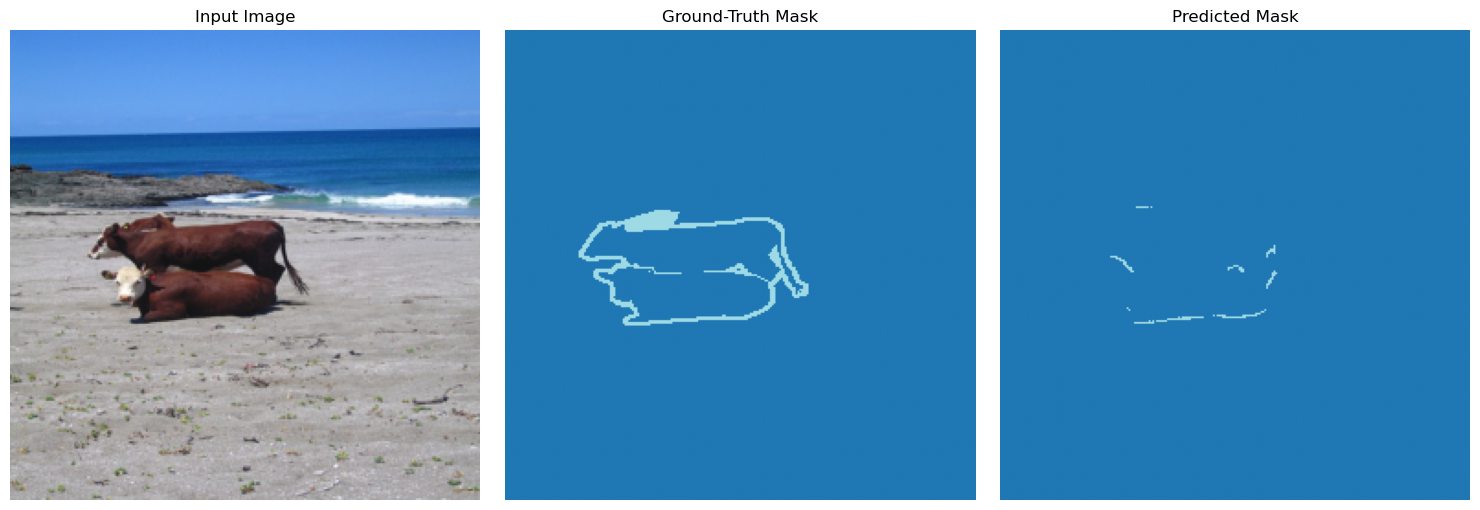

In [7]:
# model
num_classes = 21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=num_classes)
model.load_state_dict(torch.load("./3_u_net.pth", map_location=device))
model = nn.DataParallel(model.to(device))
model.eval()

# data
val_ds = VOCSegmentation(
    root="../data",
    year="2012",
    image_set="val",
    download=False,
    transform=transform_image,
    target_transform=transform_mask
)

idx = 11
img_tensor, mask_pil = val_ds[idx]
# バッチ次元を追加
x = img_tensor.unsqueeze(0).to(device)  # [1,3,256,256]

with torch.no_grad():
    logits = model(x)                     # [1,21,256,256]
    pred = torch.argmax(logits, dim=1)    # [1,256,256]
    pred_np = pred.squeeze(0).cpu().numpy().astype(np.int32)

# 元画像を NumPy に戻す（[0,1] 範囲）
img_np = img_tensor.permute(1,2,0).cpu().numpy()

# GT マスクを NumPy に
gt_np = np.array(mask_pil, dtype=np.int32)

# ─── 6. 可視化 ─────────────────────────────────
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].imshow(img_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(gt_np, cmap="tab20")
axes[1].set_title("Ground-Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred_np, cmap="tab20")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()